## Reference

### https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

## Imports, config

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

import numpy as np
import tqdm
import os
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Using TensorFlow backend.


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

## Define `batch_norm_wrapper` functions

In [3]:
# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
def batch_norm_wrapper(inputs, is_training, decay = 0.999, epsilon = 1e-3):
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        ## [cclin] https://www.tensorflow.org/api_docs/python/tf/assign
        ## Return 'pop_mean' or 'pop_var' after the assignment is done
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            ## [cclin] https://www.tensorflow.org/api_docs/python/tf/control_dependencies
            ## 'train_mean' and 'train_var' must be executed or computed
            ## before running the operations defined in the context
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)

## Define `build_graph` function

In [4]:
def build_graph(use_bn = True, is_training = True):
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    if use_bn:
        # Layer 1 with BN
        w1 = tf.Variable(w1_initial)
        z1 = tf.matmul(x,w1)
        bn1 = batch_norm_wrapper(z1, is_training)
        l1 = tf.nn.sigmoid(bn1)
    else:
        # Layer 1 without BN    
        w1 = tf.Variable(w1_initial)
        b1 = tf.Variable(tf.zeros([100]))
        z1 = tf.matmul(x,w1)+b1
        l1 = tf.nn.sigmoid(z1)

    if use_bn:
        #Layer 2 with BN
        w2 = tf.Variable(w2_initial)
        z2 = tf.matmul(l1,w2)
        bn2 = batch_norm_wrapper(z2, is_training)
        l2 = tf.nn.sigmoid(bn2)
    else:
        # Layer 2 without BN
        w2 = tf.Variable(w2_initial)
        b2 = tf.Variable(tf.zeros([100]))
        z2 = tf.matmul(l1,w2)+b2
        l2 = tf.nn.sigmoid(z2)
    
    # Softmax
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, w3))

    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    
    # Gradients of loss w.r.t. weights
    w2_grad = tf.gradients(cross_entropy, [w2])[0]
    
    if use_bn:
        return (x, y_), train_step, accuracy, y, bn2, w2, w2_grad, tf.train.Saver()
    else:
        return (x, y_), train_step, accuracy, y, z2, w2, w2_grad, tf.train.Saver()

## Build and train the models

### Try `1000` steps

In [5]:
#Build training graph, train and save the trained model

tf.reset_default_graph()
## [cclin] https://www.tensorflow.org/api_docs/python/tf/reset_default_graph
## Clears the default graph stack and resets the global default graph

(xBN, yBN_), train_step_BN, accuracy_BN, _, z2s_BN, w2s_BN, w2_grad_BN, saver_BN = build_graph(use_bn = True, is_training=True)
(x, y_), train_step, accuracy, _, z2s, w2s, w2_grad, saver = build_graph(use_bn = False, is_training=True)

w2_grad_list, w2_grad_BN_list, w2s_list, w2s_BN_list = [], [], [], []
z2s_list, z2s_BN_list, acc_list, acc_BN_list = [], [], [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(1000)):
        batch = mnist.train.next_batch(60)
        _, w2s_BN_, w2_grad_BN_ = sess.run([train_step_BN, w2s_BN, w2_grad_BN], feed_dict={xBN: batch[0], yBN_: batch[1]})
        w2s_BN_list.append(w2s_BN_)
        w2_grad_BN_list.append(w2_grad_BN_)
        _, w2s_, w2_grad_ = sess.run([train_step, w2s, w2_grad], feed_dict={x: batch[0], y_: batch[1]})
        w2s_list.append(w2s_)
        w2_grad_list.append(w2_grad_)
        if i % 50 is 0:
            res = sess.run([accuracy, accuracy_BN, z2s ,z2s_BN],
                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, \
                                      xBN: mnist.test.images, yBN_: mnist.test.labels})
            acc_list.append(res[0])
            acc_BN_list.append(res[1])
            z2s_list.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
            z2s_BN_list.append(np.mean(res[3],axis=0)) # record the mean value of z2 over the entire test set
    saved_model = saver.save(sess, './temp-save')
    saved_model_BN = saver_BN.save(sess, './temp-bn-save')
    ## [cclin] https://www.tensorflow.org/api_docs/python/tf/train/Saver
    ## 'save' method: Saves variables

w2_grad_list = np.array(w2_grad_list)
w2_grad_BN_list = np.array(w2_grad_BN_list)
w2s_list = np.array(w2s_list)
w2s_BN_list = np.array(w2s_BN_list)
z2s_list = np.array(z2s_list)
z2s_BN_list = np.array(z2s_BN_list)
acc_list = np.array(acc_list)
acc_BN_list = np.array(acc_BN_list)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.12it/s]


### Check the improvement in accuracy

Final accuracy: 0.8826
Final accuracy with BN: 0.888


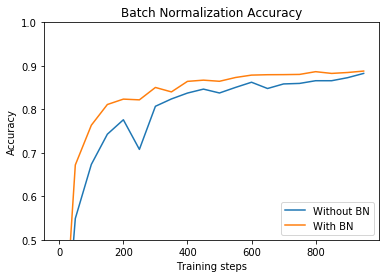

In [6]:
print("Final accuracy:", acc_list[-1])
print("Final accuracy with BN:", acc_BN_list[-1])

fig, ax = plt.subplots()

ax.plot(range(0,len(acc_list)*50,50),acc_list, label='Without BN')
ax.plot(range(0,len(acc_BN_list)*50,50),acc_BN_list, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [7]:
print(w2_grad_list.shape)
print(w2_grad_BN_list.shape)
print(w2s_list.shape)
print(w2s_BN_list.shape)
print(z2s_list.shape)
print(z2s_BN_list.shape)

(1000, 100, 100)
(1000, 100, 100)
(1000, 100, 100)
(1000, 100, 100)
(20, 100)
(20, 100)


### It can be shown that
```
w2s_list[1,i,i] = w2s_list[0,i,i] - 0.01*w2_grad_list[1,i,i]
w2s_list[2,i,i] = w2s_list[1,i,i] - 0.01*w2_grad_list[2,i,i]
...
```

In [8]:
for i in range(5):
    print('w2s_list[1,%d,%d] = %f'%(i,i,w2s_list[1,i,i]))
    print('w2s_list[0,%d,%d] - 0.01*w2_grad_list[1,%d,%d] = %f'%(i,i,i,i,w2s_list[0,i,i] - 0.01*w2_grad_list[1,i,i]))
    print('w2s_list[2,%d,%d] = %f'%(i,i,w2s_list[2,i,i]))
    print('w2s_list[1,%d,%d] - 0.01*w2_grad_list[2,%d,%d] = %f'%(i,i,i,i,w2s_list[1,i,i] - 0.01*w2_grad_list[2,i,i]))

w2s_list[1,0,0] = 0.669130
w2s_list[0,0,0] - 0.01*w2_grad_list[1,0,0] = 0.671341
w2s_list[2,0,0] = 0.664072
w2s_list[1,0,0] - 0.01*w2_grad_list[2,0,0] = 0.659176
w2s_list[1,1,1] = 1.683412
w2s_list[0,1,1] - 0.01*w2_grad_list[1,1,1] = 1.684616
w2s_list[2,1,1] = 1.681089
w2s_list[1,1,1] - 0.01*w2_grad_list[2,1,1] = 1.687888
w2s_list[1,2,2] = 0.655936
w2s_list[0,2,2] - 0.01*w2_grad_list[1,2,2] = 0.649456
w2s_list[2,2,2] = 0.660880
w2s_list[1,2,2] - 0.01*w2_grad_list[2,2,2] = 0.657051
w2s_list[1,3,3] = -0.307596
w2s_list[0,3,3] - 0.01*w2_grad_list[1,3,3] = -0.308920
w2s_list[2,3,3] = -0.310571
w2s_list[1,3,3] - 0.01*w2_grad_list[2,3,3] = -0.308721
w2s_list[1,4,4] = 0.551274
w2s_list[0,4,4] - 0.01*w2_grad_list[1,4,4] = 0.543378
w2s_list[2,4,4] = 0.549955
w2s_list[1,4,4] - 0.01*w2_grad_list[2,4,4] = 0.547688


### Check the difference of gradient magnitude

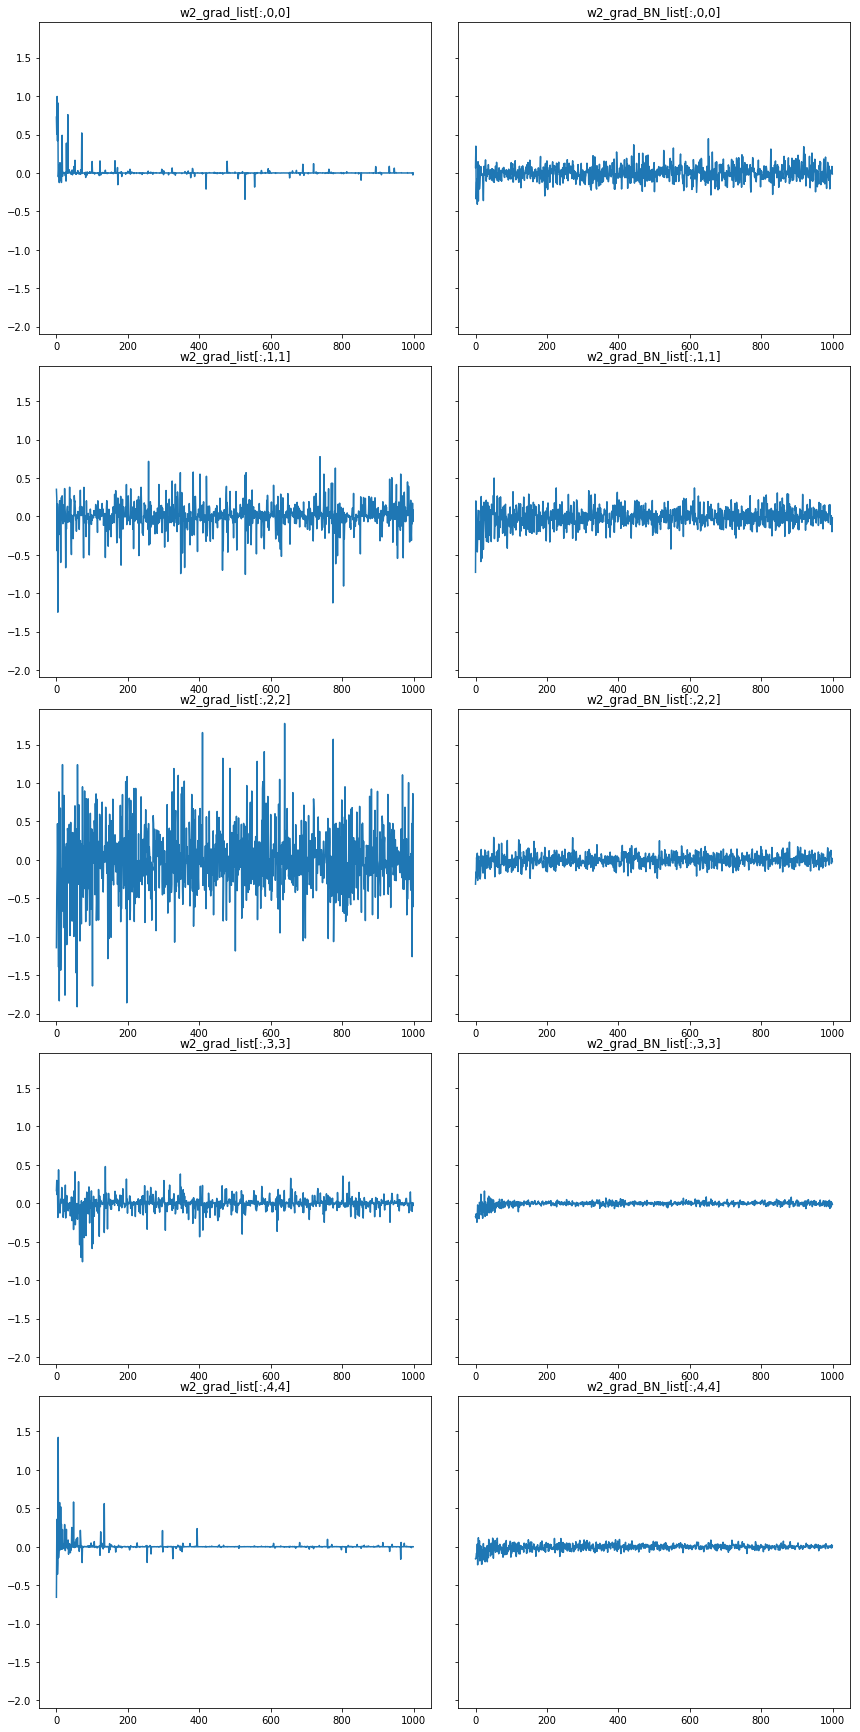

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(12,24), sharey=True)
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("w2_grad_list[:,%d,%d]"%(i,i))
    ax[1].set_title("w2_grad_BN_list[:,%d,%d]"%(i,i))
    ax[0].plot(w2_grad_list[:,i,i])
    ax[1].plot(w2_grad_BN_list[:,i,i])

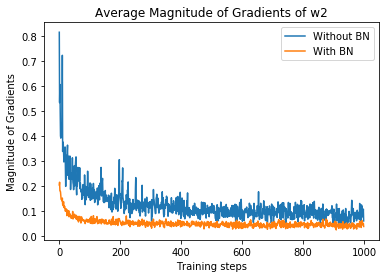

In [10]:
w2_grad_mean = np.absolute(w2_grad_list).mean(axis = (1,2))
w2_grad_BN_mean = np.absolute(w2_grad_BN_list).mean(axis = (1,2))

fig, ax = plt.subplots()

ax.plot(range(0,len(w2_grad_mean)),w2_grad_mean, label='Without BN')
ax.plot(range(0,len(w2_grad_BN_mean)),w2_grad_BN_mean, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Magnitude of Gradients')
# ax.set_ylim([0.5,1])
ax.set_title('Average Magnitude of Gradients of w2')
ax.legend(loc=1)
plt.show()

### Check the difference of z2 while testing

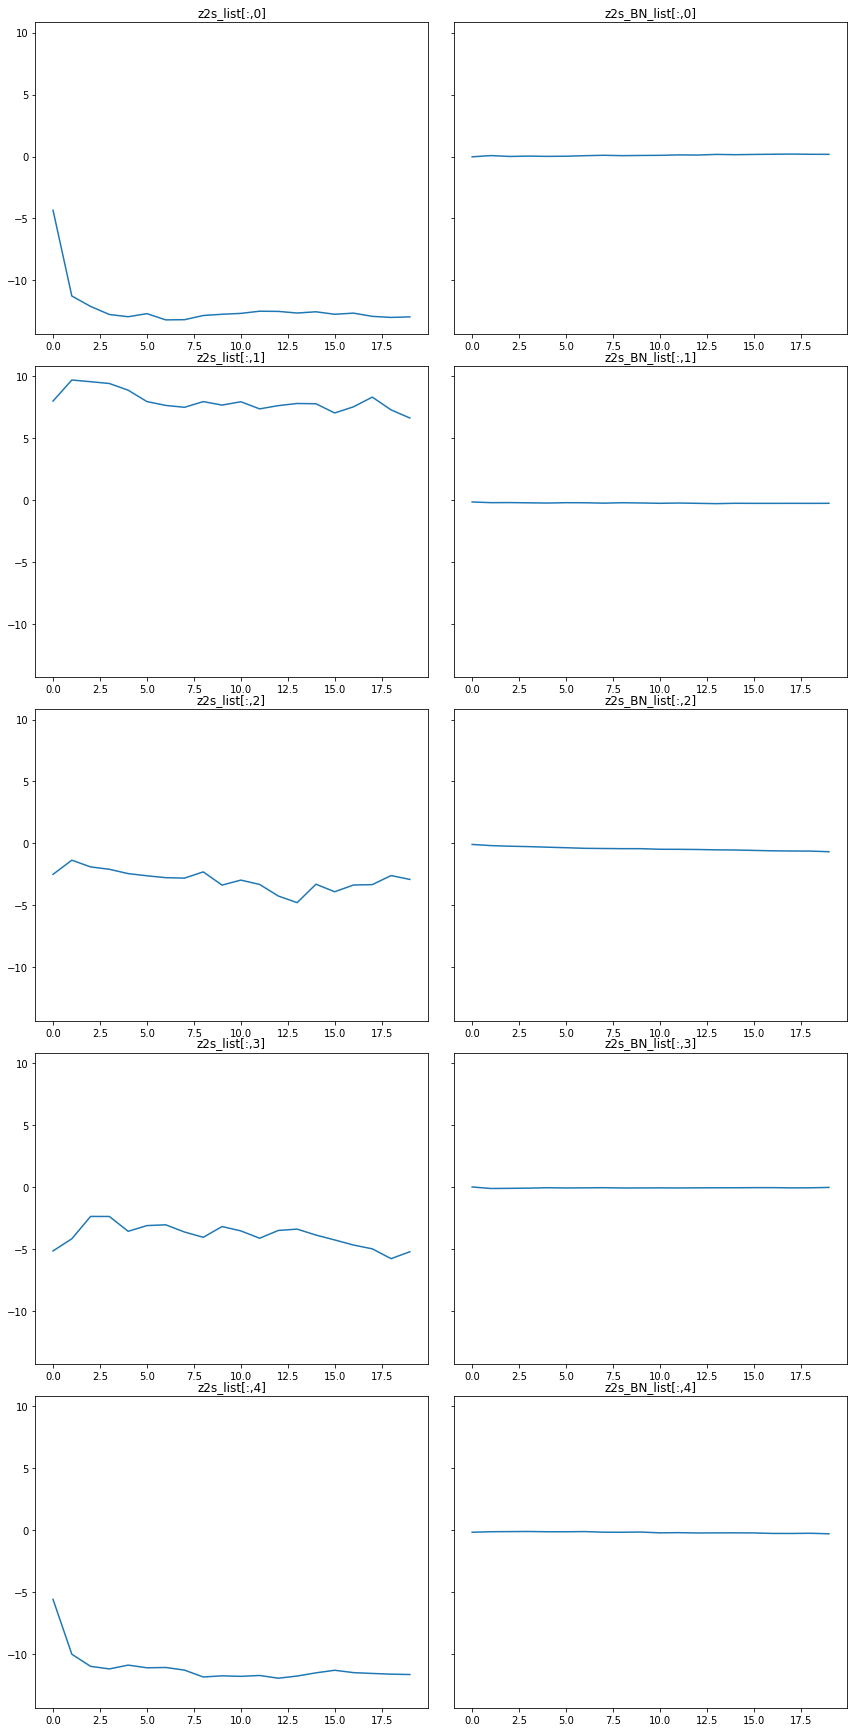

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(12,24), sharey=True)
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("z2s_list[:,%d]"%i)
    ax[1].set_title("z2s_BN_list[:,%d]"%i)
    ax[0].plot(z2s_list[:,i])
    ax[1].plot(z2s_BN_list[:,i])

### Try 40000 steps, but only record average magnitude of gradients of w2

In [12]:
#Build training graph, train and save the trained model

tf.reset_default_graph()
## [cclin] https://www.tensorflow.org/api_docs/python/tf/reset_default_graph
## Clears the default graph stack and resets the global default graph

(xBN, yBN_), train_step_BN, accuracy_BN, _, z2s_BN, w2s_BN, w2_grad_BN, saver_BN = build_graph(use_bn = True, is_training=True)
(x, y_), train_step, accuracy, _, z2s, w2s, w2_grad, saver = build_graph(use_bn = False, is_training=True)

w2_grad_list, w2_grad_BN_list = [], []
z2s_list, z2s_BN_list, acc_list, acc_BN_list = [], [], [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(40000)):
        batch = mnist.train.next_batch(60)
        _, w2_grad_BN_ = sess.run([train_step_BN, w2_grad_BN], feed_dict={xBN: batch[0], yBN_: batch[1]})
        w2_grad_BN_list.append(np.absolute(w2_grad_BN_).mean())
        _, w2_grad_ = sess.run([train_step, w2_grad], feed_dict={x: batch[0], y_: batch[1]})
        w2_grad_list.append(np.absolute(w2_grad_).mean())
        if i % 50 is 0:
            res = sess.run([accuracy, accuracy_BN, z2s ,z2s_BN],
                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, \
                                      xBN: mnist.test.images, yBN_: mnist.test.labels})
            acc_list.append(res[0])
            acc_BN_list.append(res[1])
            z2s_list.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
            z2s_BN_list.append(np.mean(res[3],axis=0)) # record the mean value of z2 over the entire test set
    saved_model = saver.save(sess, './temp-save')
    saved_model_BN = saver_BN.save(sess, './temp-bn-save')
    ## [cclin] https://www.tensorflow.org/api_docs/python/tf/train/Saver
    ## 'save' method: Saves variables

w2_grad_list = np.array(w2_grad_list)
w2_grad_BN_list = np.array(w2_grad_BN_list)
z2s_list = np.array(z2s_list)
z2s_BN_list = np.array(z2s_BN_list)
acc_list = np.array(acc_list)
acc_BN_list = np.array(acc_BN_list)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:34<00:00, 186.15it/s]


### Check the improvement in accuracy

Final accuracy: 0.9488
Final accuracy with BN: 0.97


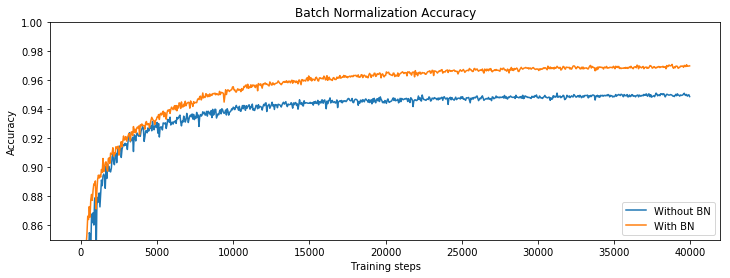

In [13]:
print("Final accuracy:", acc_list[-1])
print("Final accuracy with BN:", acc_BN_list[-1])

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(range(0,len(acc_list)*50,50),acc_list, label='Without BN')
ax.plot(range(0,len(acc_BN_list)*50,50),acc_BN_list, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.85,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [14]:
print(w2_grad_list.shape)
print(w2_grad_BN_list.shape)
print(z2s_list.shape)
print(z2s_BN_list.shape)

(40000,)
(40000,)
(800, 100)
(800, 100)


### Check the difference of gradient magnitude

(800,)
(800,)


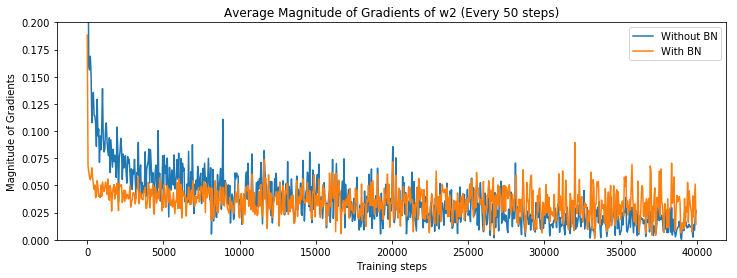

In [15]:
n = 50
w2_grad_every_n = w2_grad_list[range(0,len(w2_grad_list),n)]
w2_grad_BN_every_n = w2_grad_BN_list[range(0,len(w2_grad_BN_list),n)]
print(w2_grad_every_n.shape)
print(w2_grad_BN_every_n.shape)

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(range(0,len(w2_grad_list),n),w2_grad_every_n, label='Without BN')
ax.plot(range(0,len(w2_grad_BN_list),n),w2_grad_BN_every_n, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Magnitude of Gradients')
ax.set_ylim([0,0.2])
ax.set_title('Average Magnitude of Gradients of w2 (Every %d steps)'%n)
ax.legend(loc=1)
plt.show()

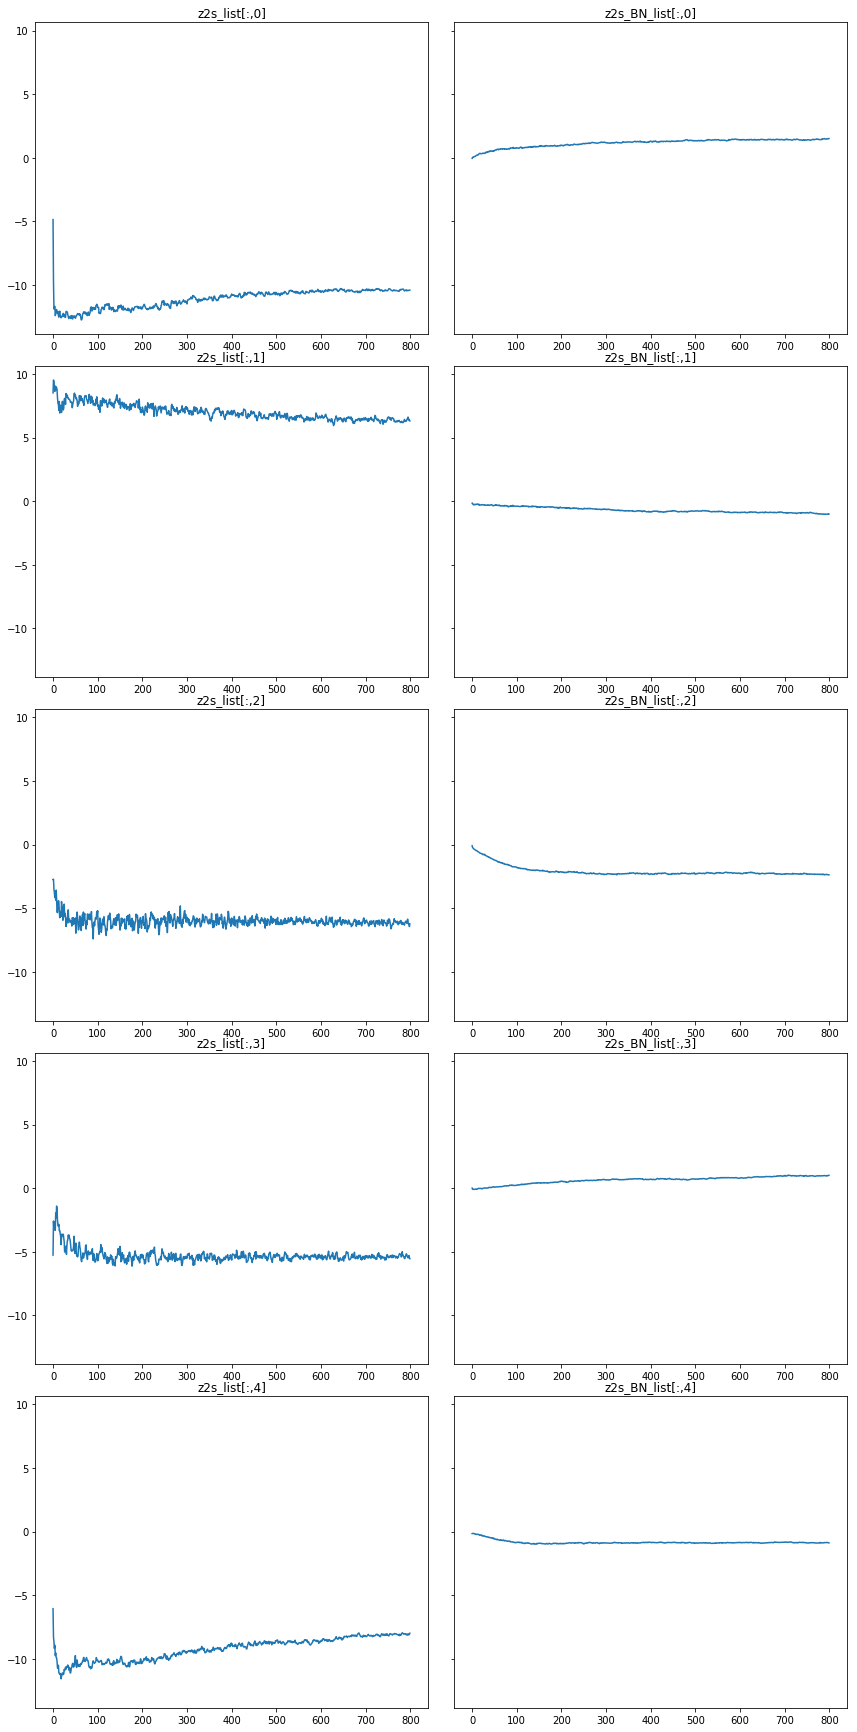

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(12,24), sharey=True)
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("z2s_list[:,%d]"%i)
    ax[1].set_title("z2s_BN_list[:,%d]"%i)
    ax[0].plot(z2s_list[:,i])
    ax[1].plot(z2s_BN_list[:,i])

### Try different batch sizes: `20`, `40`, `60`, `80`, and `100`

In [17]:
bsize_list = [20, 40, 60, 80, 100]

w2_grad_dict = {60: w2_grad_list}
w2_grad_BN_dict = {60: w2_grad_BN_list}
z2s_dict = {60: z2s_list}
z2s_BN_dict = {60: z2s_BN_list}
acc_dict = {60: acc_list}
acc_BN_dict = {60: acc_BN_list}

for batch_size in bsize_list:
    ## No need to run batch size 60 again
    if not batch_size == 60:
        print('batch_size = %d'%batch_size)
        #Build training graph, train and save the trained model
        tf.reset_default_graph()
        ## [cclin] https://www.tensorflow.org/api_docs/python/tf/reset_default_graph
        ## Clears the default graph stack and resets the global default graph

        (xBN, yBN_), train_step_BN, accuracy_BN, _, z2s_BN, w2s_BN, w2_grad_BN, saver_BN = build_graph(use_bn = True, is_training=True)
        (x, y_), train_step, accuracy, _, z2s, w2s, w2_grad, saver = build_graph(use_bn = False, is_training=True)

        w2_grad_list, w2_grad_BN_list = [], []
        z2s_list, z2s_BN_list, acc_list, acc_BN_list = [], [], [], []
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in tqdm.tqdm(range(40000)):
                batch = mnist.train.next_batch(batch_size)
                _, w2_grad_BN_ = sess.run([train_step_BN, w2_grad_BN], feed_dict={xBN: batch[0], yBN_: batch[1]})
                w2_grad_BN_list.append(np.absolute(w2_grad_BN_).mean())
                _, w2_grad_ = sess.run([train_step, w2_grad], feed_dict={x: batch[0], y_: batch[1]})
                w2_grad_list.append(np.absolute(w2_grad_).mean())
                if i % 50 is 0:
                    res = sess.run([accuracy, accuracy_BN, z2s ,z2s_BN],
                                   feed_dict={x: mnist.test.images, y_: mnist.test.labels, \
                                              xBN: mnist.test.images, yBN_: mnist.test.labels})
                    acc_list.append(res[0])
                    acc_BN_list.append(res[1])
                    z2s_list.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
                    z2s_BN_list.append(np.mean(res[3],axis=0)) # record the mean value of z2 over the entire test set
            saved_model = saver.save(sess, './temp-save-bsize%d'%batch_size)
            saved_model_BN = saver_BN.save(sess, './temp-bn-save-bsize%d'%batch_size)
            ## [cclin] https://www.tensorflow.org/api_docs/python/tf/train/Saver
            ## 'save' method: Saves variables

        w2_grad_dict[batch_size] = np.array(w2_grad_list)
        w2_grad_BN_dict[batch_size] = np.array(w2_grad_BN_list)
        z2s_dict[batch_size] = np.array(z2s_list)
        z2s_BN_dict[batch_size] = np.array(z2s_BN_list)
        acc_dict[batch_size] = np.array(acc_list)
        acc_BN_dict[batch_size] = np.array(acc_BN_list)

batch_size = 20


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:33<00:00, 187.16it/s]


batch_size = 40


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:53<00:00, 171.08it/s]


batch_size = 80


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:41<00:00, 180.38it/s]


batch_size = 100


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:49<00:00, 174.46it/s]


In [22]:
bsize_list2 = [5, 10, 15]

for batch_size in bsize_list2:
    ## No need to run batch size 60 again
    if not batch_size == 60:
        print('batch_size = %d'%batch_size)
        #Build training graph, train and save the trained model
        tf.reset_default_graph()
        ## [cclin] https://www.tensorflow.org/api_docs/python/tf/reset_default_graph
        ## Clears the default graph stack and resets the global default graph

        (xBN, yBN_), train_step_BN, accuracy_BN, _, z2s_BN, w2s_BN, w2_grad_BN, saver_BN = build_graph(use_bn = True, is_training=True)
        (x, y_), train_step, accuracy, _, z2s, w2s, w2_grad, saver = build_graph(use_bn = False, is_training=True)

        w2_grad_list, w2_grad_BN_list = [], []
        z2s_list, z2s_BN_list, acc_list, acc_BN_list = [], [], [], []
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in tqdm.tqdm(range(40000)):
                batch = mnist.train.next_batch(batch_size)
                _, w2_grad_BN_ = sess.run([train_step_BN, w2_grad_BN], feed_dict={xBN: batch[0], yBN_: batch[1]})
                w2_grad_BN_list.append(np.absolute(w2_grad_BN_).mean())
                _, w2_grad_ = sess.run([train_step, w2_grad], feed_dict={x: batch[0], y_: batch[1]})
                w2_grad_list.append(np.absolute(w2_grad_).mean())
                if i % 50 is 0:
                    res = sess.run([accuracy, accuracy_BN, z2s ,z2s_BN],
                                   feed_dict={x: mnist.test.images, y_: mnist.test.labels, \
                                              xBN: mnist.test.images, yBN_: mnist.test.labels})
                    acc_list.append(res[0])
                    acc_BN_list.append(res[1])
                    z2s_list.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
                    z2s_BN_list.append(np.mean(res[3],axis=0)) # record the mean value of z2 over the entire test set
            saved_model = saver.save(sess, './temp-save-bsize%d'%batch_size)
            saved_model_BN = saver_BN.save(sess, './temp-bn-save-bsize%d'%batch_size)
            ## [cclin] https://www.tensorflow.org/api_docs/python/tf/train/Saver
            ## 'save' method: Saves variables

        w2_grad_dict[batch_size] = np.array(w2_grad_list)
        w2_grad_BN_dict[batch_size] = np.array(w2_grad_BN_list)
        z2s_dict[batch_size] = np.array(z2s_list)
        z2s_BN_dict[batch_size] = np.array(z2s_BN_list)
        acc_dict[batch_size] = np.array(acc_list)
        acc_BN_dict[batch_size] = np.array(acc_BN_list)

batch_size = 5


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:22<00:00, 197.52it/s]


batch_size = 10


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:20<00:00, 199.34it/s]


batch_size = 15


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:32<00:00, 188.33it/s]


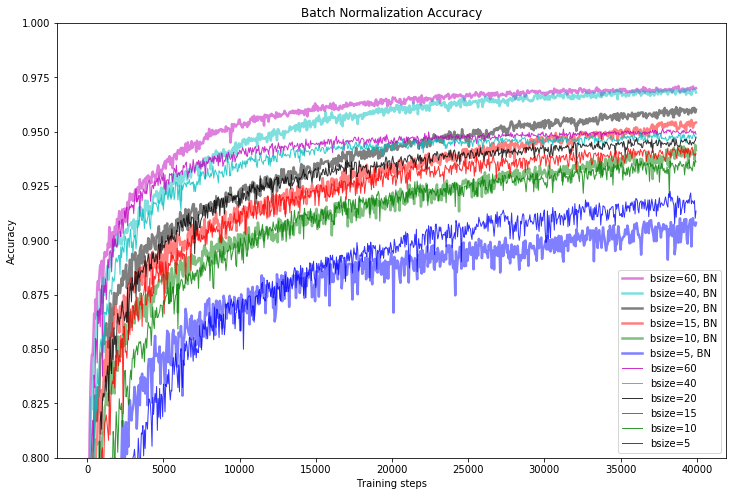

In [28]:
bsize_list = [5, 10, 15, 20, 40, 60]

fig, ax = plt.subplots(figsize=(12,8))
color_list = ['b', 'g', 'r', 'k', 'c', 'm']
## Plot accuracy with BN first
## (sort by accuracy in decreasing order)
final_acc_BN_list = [acc_BN_dict[i][400] for i in bsize_list]
for idx in sorted(range(len(final_acc_BN_list)), key=lambda k: -final_acc_BN_list[k]):
    ax.plot(range(0,len(acc_BN_dict[bsize_list[idx]])*50,50),
            acc_BN_dict[bsize_list[idx]],
            color = color_list[idx], alpha = 0.5, linewidth = 2.5,
            label='bsize=%d, BN'%(bsize_list[idx]))
## Plot accuracy without BN
for idx in sorted(range(len(final_acc_BN_list)), key=lambda k: -final_acc_BN_list[k]):
    ax.plot(range(0,len(acc_dict[bsize_list[idx]])*50,50),
            acc_dict[bsize_list[idx]],
            color = color_list[idx], alpha = 0.8, linewidth = 1,
            label='bsize=%d'%(bsize_list[idx]))
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

# Rewrite code into class

In [35]:
class Model_DNN(object):
    def __init__(self, model_name = 'DNN', n_steps = 40000,
                 input_size = 784, output_size = 10,
                 batch_size = 64, hidden_size_1 = 100, hidden_size_2 = 100,
                 act_fn = tf.nn.sigmoid, opt_fn = tf.train.GradientDescentOptimizer,
                 learning_rate = 0.01,
                 use_bn = True, momentum = 0.999, epsilon = 1e-3, is_training = True,
                 save_dir='save_DNN'):
        self.model_name = model_name
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.act_fn = act_fn
        self.opt_fn = opt_fn
        self.learning_rate = learning_rate
        self.use_bn = use_bn
        self.momentum = momentum
        self.epsilon = epsilon
        self.is_training = is_training
        self.save_dir = save_dir
    
    def batch_norm_wrapper(self, inputs, is_training, momentum = 0.999, epsilon = 1e-3):
        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

        if is_training:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(pop_mean,
                                   pop_mean * momentum + batch_mean * (1 - momentum))
            train_var = tf.assign(pop_var,
                                  pop_var * momentum + batch_var * (1 - momentum))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, beta, scale, epsilon)
        else:
            return tf.nn.batch_normalization(inputs,
                pop_mean, pop_var, beta, scale, epsilon)
    
    def build_model(self):
        # Placeholders
        self.x = tf.placeholder(tf.float32, shape=[None, self.input_size])
        self.y_ = tf.placeholder(tf.float32, shape=[None, self.output_size])
        
        # The first hidden layer
        self.w1 = tf.Variable(np.random.normal(size=(self.input_size,self.hidden_size_1)).astype(np.float32))
        if self.use_bn:
            self.z1 = tf.matmul(self.x,self.w1)
            self.bn1 = self.batch_norm_wrapper(self.z1, self.is_training, self.momentum, self.epsilon)
            self.l1 = self.act_fn(self.bn1)
        else:
            self.b1 = tf.Variable(tf.zeros([self.hidden_size_1]))
            self.z1 = tf.matmul(self.x,self.w1)+self.b1
            self.l1 = self.act_fn(self.z1)
        
        # The second hidden layer
        self.w2 = tf.Variable(np.random.normal(size=(self.hidden_size_1,self.hidden_size_2)).astype(np.float32))
        if self.use_bn:
            self.z2 = tf.matmul(self.l1,self.w2)
            self.bn2 = self.batch_norm_wrapper(self.z2, self.is_training, self.momentum, self.epsilon)
            self.l2 = self.act_fn(self.bn2)
        else:
            self.b2 = tf.Variable(tf.zeros([self.hidden_size_2]))
            self.z2 = tf.matmul(self.l1,self.w2)+self.b2
            self.l2 = self.act_fn(self.z2)

        # The output layer: always use softmax
        self.w3 = tf.Variable(np.random.normal(size=(self.hidden_size_2,self.output_size)).astype(np.float32))
        self.b3 = tf.Variable(tf.zeros([self.output_size]))
        self.y  = tf.nn.softmax(tf.matmul(self.l2, self.w3)+self.b3)

        # Loss, Optimizer and Predictions
        self.cross_entropy = -tf.reduce_sum(self.y_*tf.log(self.y))

        self.train_step = self.opt_fn(self.learning_rate).minimize(self.cross_entropy)

        self.correct_prediction = tf.equal(tf.arg_max(self.y,1),tf.arg_max(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction,tf.float32))

        # Gradients of loss w.r.t. weights
        self.w2_grad = tf.gradients(self.cross_entropy, [self.w2])[0]
        
        ## Keep the last 5 checkpoints
        self.saver = tf.train.Saver()
    
    def train(self, sess):
        self.w2_list, self.w2_grad_list, self.accuracy_list, self.z2_list = [], [], [], []
        for idx in tqdm.tqdm(range(self.n_steps)):
            batch = mnist.train.next_batch(self.batch_size)
            _, self.w2_, self.w2_grad_ = sess.run([self.train_step, self.w2, self.w2_grad],
                                                  feed_dict={self.x: batch[0], self.y_: batch[1]})
            self.w2_list.append(self.w2_)
            self.w2_grad_list.append(self.w2_grad_)
            if idx % 50 is 0:
                self.accuracy_, self.z2_ = sess.run([self.accuracy, self.z2],
                                                    feed_dict={self.x: mnist.test.images,
                                                               self.y_: mnist.test.labels})
                self.accuracy_list.append(self.accuracy_)
                self.z2_list.append(np.mean(self.z2_, axis = 0))
            if idx % 500 is 0:
                self.save(sess, self.save_dir, idx)
        self.w2_list = np.array(self.w2_list)
        self.w2_grad_list = np.array(self.w2_grad_list)
        self.accuracy_list = np.array(self.accuracy_list)
        self.z2_list = np.array(self.z2_list)
    
    @property
    def model_dir(self):
        model_dir = "bsize{}_{}_{}".format(self.batch_size,
                                           self.act_fn.__qualname__,
                                           self.opt_fn.__qualname__)
        if self.use_bn:
            model_dir = model_dir + '_BN'
        return model_dir
    
    def save(self, sess, save_dir, step):
        model_name = self.model_name + ".model"
        save_dir = os.path.join(save_dir, self.model_dir)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.saver.save(sess, os.path.join(save_dir, model_name), global_step=step)

## Try different batch sizes

In [3]:
bsize_list = [4, 16, 64, 256]

w2_BN_dict, w2_grad_BN_dict, accuracy_BN_dict, z2_BN_dict = {}, {}, {}, {}
w2_dict, w2_grad_dict, accuracy_dict, z2_dict = {}, {}, {}, {}

for bsize in bsize_list:
    ## run model with BN:
    model_dnn = Model_DNN(n_steps = 40000, batch_size = bsize)
    model_dnn.build_model()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model_dnn.train(sess)
    w2_BN_dict[bsize] = model_dnn.w2_list
    w2_grad_BN_dict[bsize] = model_dnn.w2_grad_list
    accuracy_BN_dict[bsize] = model_dnn.accuracy_list
    z2_BN_dict[bsize] = model_dnn.z2_list
    ## run model without BN:
    model_dnn = Model_DNN(n_steps = 40000, batch_size = bsize, use_bn = False)
    model_dnn.build_model()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model_dnn.train(sess)
    w2_dict[bsize] = model_dnn.w2_list
    w2_grad_dict[bsize] = model_dnn.w2_grad_list
    accuracy_dict[bsize] = model_dnn.accuracy_list
    z2_dict[bsize] = model_dnn.z2_list


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [07:57<00:00, 83.69it/s]


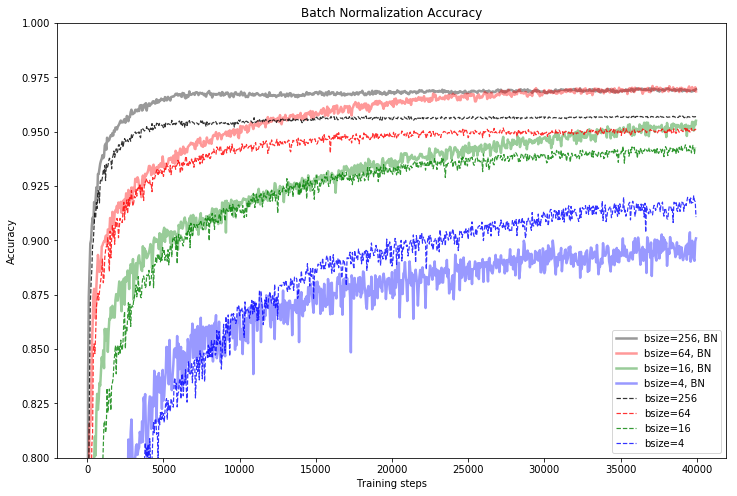

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
color_list = ['b', 'g', 'r', 'k', 'c', 'm']

## (sort by accuracy in decreasing order)
final_accuracy_BN_dict = [accuracy_BN_dict[i][400] for i in bsize_list]
decreasing_order = sorted(range(len(final_accuracy_BN_dict)),
                          key=lambda k: -final_accuracy_BN_dict[k])

## Plot accuracy with BN
for idx in decreasing_order:
    ax.plot(range(0,len(accuracy_BN_dict[bsize_list[idx]])*50,50),
            accuracy_BN_dict[bsize_list[idx]],
            color = color_list[idx], alpha = 0.4, linewidth = 2.5,
            label='bsize=%d, BN'%(bsize_list[idx]))

## Plot accuracy without BN
for idx in decreasing_order:
    ax.plot(range(0,len(accuracy_dict[bsize_list[idx]])*50,50),
            accuracy_dict[bsize_list[idx]],
            color = color_list[idx], alpha = 0.8, linewidth = 1.2,
            linestyle = '--',
            label='bsize=%d'%(bsize_list[idx]))

ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.savefig('save_DNN/accuracy_vs_batch_sizes.png')
plt.show()

In [29]:
print(w2_BN_dict[64].shape)
print(w2_grad_BN_dict[64].shape)
print(accuracy_BN_dict[64].shape)
print(z2_BN_dict[64].shape)
print(w2_dict[64].shape)
print(w2_grad_dict[64].shape)
print(accuracy_dict[64].shape)
print(z2_dict[64].shape)

(40000, 100, 100)
(40000, 100, 100)
(800,)
(800, 100)
(40000, 100, 100)
(40000, 100, 100)
(800,)
(800, 100)


In [ ]:
import pickle

with open('save_DNN/w2_BN_dict.pkl', 'wb') as f:
    pickle.dump(w2_BN_dict, f)
with open('save_DNN/w2_grad_BN_dict.pkl', 'wb') as f:
    pickle.dump(w2_grad_BN_dict, f)
with open('save_DNN/accuracy_BN_dict.pkl', 'wb') as f:
    pickle.dump(accuracy_BN_dict, f)
with open('save_DNN/z2_BN_dict.pkl', 'wb') as f:
    pickle.dump(z2_BN_dict, f)

with open('save_DNN/w2_dict.pkl', 'wb') as f:
    pickle.dump(w2_dict, f)
with open('save_DNN/w2_grad_dict.pkl', 'wb') as f:
    pickle.dump(w2_grad_dict, f)
with open('save_DNN/accuracy_dict.pkl', 'wb') as f:
    pickle.dump(accuracy_dict, f)
with open('save_DNN/z2_dict.pkl', 'wb') as f:
    pickle.dump(z2_dict, f)

## Try different activation functions

In [36]:
## Use default batch size (64)
## Save sigmoid result first
w2_BN_list_sigmoid = w2_BN_dict[64]
w2_grad_BN_list_sigmoid = w2_grad_BN_dict[64]
accuracy_BN_list_sigmoid = accuracy_BN_dict[64]
z2_BN_list_sigmoid = z2_BN_dict[64]
w2_list_sigmoid = w2_dict[64]
w2_grad_list_sigmoid = w2_grad_dict[64]
accuracy_list_sigmoid = accuracy_dict[64]
z2_list_sigmoid = z2_dict[64]

In [41]:
## Define leaky-relu with leak = 0.2 and __qualname = 'lrelu'
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [43]:
act_fn_list = [tf.nn.relu, lrelu, tf.tanh, tf.nn.softplus]

w2_BN_dict, w2_grad_BN_dict, accuracy_BN_dict, z2_BN_dict = {}, {}, {}, {}
w2_dict, w2_grad_dict, accuracy_dict, z2_dict = {}, {}, {}, {}

for afn in act_fn_list:
    key = afn.__qualname__
    ## run model with BN:
    model_dnn = Model_DNN(n_steps = 40000, act_fn = afn)
    model_dnn.build_model()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model_dnn.train(sess)
    w2_BN_dict[key] = model_dnn.w2_list
    w2_grad_BN_dict[key] = model_dnn.w2_grad_list
    accuracy_BN_dict[key] = model_dnn.accuracy_list
    z2_BN_dict[key] = model_dnn.z2_list
    ## run model without BN:
    model_dnn = Model_DNN(n_steps = 40000, act_fn = afn, use_bn = False)
    model_dnn.build_model()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model_dnn.train(sess)
    w2_dict[key] = model_dnn.w2_list
    w2_grad_dict[key] = model_dnn.w2_grad_list
    accuracy_dict[key] = model_dnn.accuracy_list
    z2_dict[key] = model_dnn.z2_list


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [17:05<00:00, 39.01it/s]


In [45]:
## Restore sigmoid results
w2_BN_dict['sigmoid'] = w2_BN_list_sigmoid
w2_grad_BN_dict['sigmoid'] = w2_grad_BN_list_sigmoid
accuracy_BN_dict['sigmoid'] = accuracy_BN_list_sigmoid
z2_BN_dict['sigmoid'] = z2_BN_list_sigmoid
w2_dict['sigmoid'] = w2_list_sigmoid
w2_grad_dict['sigmoid'] = w2_grad_list_sigmoid
accuracy_dict['sigmoid'] = accuracy_list_sigmoid
z2_dict['sigmoid'] = z2_list_sigmoid

In [47]:
key_list = list(accuracy_dict.keys())
print(key_list)

['lrelu', 'relu', 'softplus', 'tanh', 'sigmoid']


In [54]:
for key in key_list:
    print(key)
#     print(w2_BN_dict[key].shape)
#     print(w2_grad_BN_dict[key].shape)
#     print(accuracy_BN_dict[key].shape)
#     print(z2_BN_dict[key].shape)
#     print(w2_dict[key].shape)
#     print(w2_grad_dict[key].shape)
#     print(accuracy_dict[key].shape)
#     print(z2_dict[key].shape)
    print(accuracy_BN_dict[key])

lrelu
[ 0.17609999  0.73650002  0.7773      0.82610005  0.82900006  0.8477
  0.85400009  0.86080009  0.87340009  0.87610012  0.8847      0.88940006
  0.88910007  0.89010012  0.8950001   0.9004001   0.9029001   0.90480006
  0.90810007  0.90850013  0.91770005  0.91590005  0.91220003  0.9058001
  0.91030008  0.91030008  0.9198001   0.91990006  0.9223001   0.91360015
  0.91570014  0.9216001   0.92410016  0.92510009  0.91500008  0.92340004
  0.92570013  0.92560011  0.9309001   0.92930013  0.93010014  0.93590015
  0.92980015  0.93140012  0.93120009  0.93210012  0.93250012  0.93310016
  0.93690008  0.92840016  0.92720014  0.93680006  0.93270004  0.93450004
  0.93660009  0.93680018  0.93990016  0.94030011  0.94020015  0.94050014
  0.93930018  0.94140005  0.94130015  0.9410001   0.93890017  0.93570018
  0.93790007  0.94040018  0.94080007  0.94140017  0.94220012  0.94310009
  0.94250011  0.94430012  0.94050014  0.94330013  0.94270021  0.94640011
  0.94800001  0.94700015  0.94450009  0.94430017  

  0.09799999  0.098     ]
relu
[ 0.21489996  0.70370001  0.77310002  0.81440002  0.83859998  0.85460007
  0.86420012  0.87160009  0.85850006  0.8792001   0.88150007  0.87820005
  0.88060004  0.88760018  0.89540017  0.90160012  0.90130007  0.90280008
  0.90110004  0.9072001   0.91340017  0.91600013  0.91050017  0.90490013
  0.91100001  0.9169001   0.92020005  0.91930008  0.92000008  0.92650014
  0.9259001   0.92730016  0.92630011  0.92860007  0.92220002  0.92460001
  0.92370015  0.92670012  0.92950016  0.93070012  0.92730016  0.92980009
  0.93430018  0.92950016  0.93160009  0.93440008  0.93320012  0.93660009
  0.92760009  0.93660009  0.93580019  0.93740016  0.93440008  0.93550014
  0.93810016  0.93930012  0.93930006  0.93750012  0.94060004  0.93590009
  0.93840009  0.93650013  0.94000018  0.94400012  0.94150013  0.94250011
  0.94270015  0.94140011  0.94270015  0.9435001   0.94440013  0.94390017
  0.94470018  0.9434002   0.94100004  0.94310021  0.94390017  0.9453001
  0.9435001   0.94550

  0.97160012  0.97030014]
softplus
[ 0.1         0.73799992  0.82110012  0.84710002  0.79220009  0.84920007
  0.85970008  0.87460005  0.85460007  0.88760012  0.8652001   0.88830012
  0.8871001   0.89550006  0.89830017  0.90350008  0.90010005  0.90240014
  0.90550011  0.90140009  0.90590012  0.90690011  0.90950012  0.89510006
  0.91920006  0.91180009  0.90900016  0.91240013  0.9162001   0.91080004
  0.91590011  0.92430007  0.9108001   0.91580009  0.92390007  0.92760003
  0.92030013  0.92420006  0.92980015  0.92800009  0.92510015  0.92500007
  0.93070006  0.92350012  0.92810011  0.92940009  0.93130004  0.93160009
  0.93360019  0.93360013  0.93260002  0.93290013  0.9345001   0.93590015
  0.93470007  0.93390018  0.93200016  0.93230015  0.93610013  0.93340003
  0.93300009  0.93700004  0.9363001   0.94050014  0.94250011  0.93830013
  0.93510008  0.93940008  0.93610013  0.94340008  0.93570018  0.94010019
  0.94220006  0.94200015  0.9399001   0.94520015  0.94500011  0.94210011
  0.94310015  0.

  0.098       0.09799999  0.098     ]
tanh
[ 0.17669998  0.73969996  0.83150005  0.85140008  0.86510009  0.86290008
  0.85790002  0.86940014  0.87910008  0.89399999  0.88450015  0.89410013
  0.89920014  0.88900006  0.90420008  0.90390003  0.90570009  0.90780014
  0.89830005  0.90680003  0.90980011  0.90430009  0.9143002   0.91310012
  0.91880012  0.91620004  0.89960009  0.92150003  0.91950011  0.92020005
  0.91860008  0.9162001   0.92370009  0.92300004  0.92710012  0.92790014
  0.92460006  0.93210006  0.9277001   0.92890006  0.9284001   0.92550015
  0.92450011  0.93110013  0.92640007  0.92080009  0.93340015  0.93470013
  0.93320018  0.93070012  0.93850011  0.93820012  0.94140017  0.94050014
  0.93980014  0.94100004  0.93850011  0.93550014  0.94250011  0.94010019
  0.93890005  0.9410001   0.94020015  0.93950009  0.94230008  0.94090015
  0.94620007  0.94580013  0.94600016  0.93950009  0.94050014  0.94550008
  0.94200009  0.94430012  0.94840014  0.94510013  0.94090021  0.94750005
  0.9479

  0.96970016  0.97120011]
sigmoid
[ 0.10299999  0.69329995  0.77759993  0.81550014  0.81469995  0.82190001
  0.85020006  0.86030006  0.87450016  0.87770009  0.87580007  0.8641001
  0.87900007  0.8858      0.89330018  0.8907001   0.88550007  0.88580006
  0.88720006  0.89710009  0.89770007  0.89880013  0.89950007  0.89950007
  0.90190005  0.90230006  0.8979001   0.90500009  0.9048      0.9036001
  0.91030002  0.90750009  0.90500009  0.91310012  0.9083001   0.90710014
  0.91280007  0.91380006  0.91430014  0.91590011  0.91270006  0.9174
  0.91500008  0.91650015  0.91770011  0.91270012  0.91590011  0.91820008
  0.91360003  0.91890013  0.91700006  0.9216001   0.92140007  0.91900009
  0.92320019  0.91650009  0.92070007  0.92050004  0.92430013  0.91870016
  0.92420006  0.92250007  0.92310011  0.92830014  0.92800003  0.92700011
  0.92900014  0.92790014  0.92500013  0.92290008  0.92510015  0.91990012
  0.92770016  0.92980009  0.92780006  0.92550015  0.93060011  0.92970014
  0.93050009  0.9311000

  0.97040015  0.96850008]


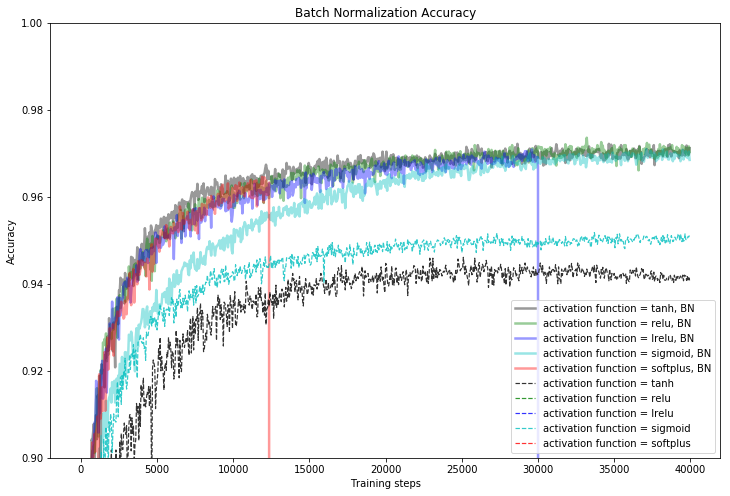

In [49]:
fig, ax = plt.subplots(figsize=(12,8))
color_list = ['b', 'g', 'r', 'k', 'c', 'm']

## (sort by accuracy in decreasing order)
final_accuracy_BN_dict = [accuracy_BN_dict[i][400] for i in key_list]
decreasing_order = sorted(range(len(final_accuracy_BN_dict)),
                          key=lambda k: -final_accuracy_BN_dict[k])

## Plot accuracy with BN
for idx in decreasing_order:
    ax.plot(range(0,len(accuracy_BN_dict[key_list[idx]])*50,50),
            accuracy_BN_dict[key_list[idx]],
            color = color_list[idx], alpha = 0.4, linewidth = 2.5,
            label='activation function = %s, BN'%(key_list[idx]))

## Plot accuracy without BN
for idx in decreasing_order:
    ax.plot(range(0,len(accuracy_dict[key_list[idx]])*50,50),
            accuracy_dict[key_list[idx]],
            color = color_list[idx], alpha = 0.8, linewidth = 1.2,
            linestyle = '--',
            label='activation function = %s'%(key_list[idx]))

ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.9,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.savefig('save_DNN/accuracy_vs_batch_sizes.png')
plt.show()